## Micro MNIST Autoencoder

This Autoencoder, which was trained on keras' mnist dataset, was built with the primary goal of minimizing the latent dimensionality. because of this a minimum latent dimensionality of just three parameters was achieved, allowing me to plot all possible configurations in a single 3-dimensional image.


---


To use the interactive portions of this colab it first needs to be run locally. This process should take under a minute and is not required for regular viewing of the colab.

In [200]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

import math

r_seed = 2

from numpy.random import seed
seed(r_seed)
from tensorflow.random import set_seed
set_seed(r_seed)

In [201]:
# load the MNIST dataset, normalize it, and reshape
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train.reshape( (-1, 28, 28, 1) ), x_test.reshape( (-1, 28, 28, 1) )

x_train, x_test = x_train / 255, x_test / 255

print("Xs shape:", x_train.shape)

Xs shape: (60000, 28, 28, 1)


In [202]:
ENCODED_DIM = 3

# Constructing the models

In [203]:
# Create the keras models (encoder, decoder, autoencoder)
i = Input( shape=(28, 28, 1, ) )

x = Conv2D( 2, (4, 4), activation="relu" )(i)
x = MaxPooling2D()(x)
x = Conv2D( 4, (2, 2), activation="relu" )(i)
x = MaxPooling2D()(x)
x = Conv2D( 4, (2, 2), activation="relu" )(i)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(ENCODED_DIM, activation="tanh")(x)

encoder = Model(i, x)
# print(encoder.summary())

In [204]:
i = Input( shape=(ENCODED_DIM, ) )

x = Dense( 32, activation="relu" )(i)
x = Dense( 32, activation="relu" )(x)

x = Dense( 512, activation="relu" )(x)
x = Dense( 512, activation="relu" )(x)

x = Dense( 784, activation="sigmoid" )(x)

x = Reshape( (28, 28, 1,) )(x)

decoder = Model(i, x)
# print(decoder.summary())

In [205]:
i = Input( shape=(28, 28, 1, ) )
x = encoder(i)
x = decoder(x)

autoencoder = Model(i, x)
# print(autoencoder.summary())

In [206]:
# compile the autoencoder
autoencoder.compile(loss='binary_crossentropy', optimizer='rmsprop')

# Training process

In [207]:
# train the autoencoder
EPOCHS = 50
BATCH_SIZE = 128
TRAINING_SIZE = 20000

# loss, val_loss
history=[[], []]

for e in range(EPOCHS):
    if e % 20 == 0:
        print("Epoch:", e)

    if e % 5 == 0:
        verbose = 2
    else:
        verbose = 0

    hist = autoencoder.fit(
        x=x_train[:TRAINING_SIZE],
        y=x_train[:TRAINING_SIZE],
        batch_size=BATCH_SIZE,
        verbose=verbose,
        validation_data=(x_test, x_test)
        )
    
    history[0].append(hist.history["loss"])
    history[1].append(hist.history["val_loss"])

Epoch: 0
157/157 - 2s - loss: 0.2755 - val_loss: 0.2605
157/157 - 1s - loss: 0.1957 - val_loss: 0.1906
157/157 - 1s - loss: 0.1747 - val_loss: 0.1730
157/157 - 1s - loss: 0.1669 - val_loss: 0.1688
Epoch: 20
157/157 - 1s - loss: 0.1627 - val_loss: 0.1646
157/157 - 1s - loss: 0.1595 - val_loss: 0.1635
157/157 - 1s - loss: 0.1571 - val_loss: 0.1637
157/157 - 1s - loss: 0.1553 - val_loss: 0.1629
Epoch: 40
157/157 - 1s - loss: 0.1538 - val_loss: 0.1618
157/157 - 1s - loss: 0.1525 - val_loss: 0.1608


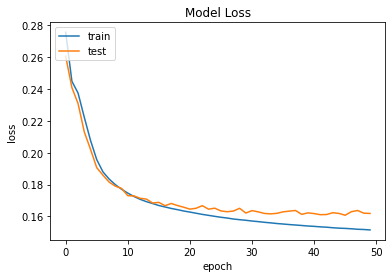

In [208]:
# render a table of the model's loss over time
plt.plot(history[0])
plt.plot(history[1])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

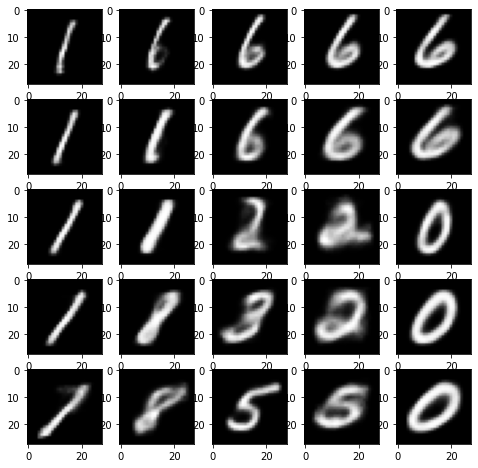

In [209]:
# plot a collection of the decoder's outputs
w=10
h=10
s=5

fig=plt.figure( figsize=(8, 8) )
for i in range( 1, s*s+1 ):
    encoded_rep = [
        (((i-1) % s) / (s/2) - 1),
        ((math.floor(((i-1)/ s))) / (s/2)) - 1,             
    ]

    for j in range(ENCODED_DIM - 2):
        encoded_rep.append(0.5)

    img = decoder.predict( [encoded_rep] ).reshape( 28, 28 )
    fig.add_subplot( s, s, i )
    plt.imshow( img, cmap="gray" )

plt.show()

In [210]:
# create a live panel that user can mess arround with
def liveDecoded(e1, e2, e3):
    img = decoder.predict([[e1, e2, e3]])
    img = img.reshape( (28, 28) )

    plt.imshow(img, cmap="gray")
    plt.show()

# Interactive Widgets

In [211]:
widgets.interact(
    liveDecoded,
    e1 = (-1, 1, 0.1),
    e2 = (-1, 1, 0.1),
    e3 = (-1, 1, 0.1))


interactive(children=(FloatSlider(value=0.0, description='e1', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.liveDecoded>

In [212]:
# create a larger live panel with only a single slider
def gridLiveDemo(e):
    fig=plt.figure( figsize=(8, 8) )
    for i in range( 1, s*s+1 ):
        encoded_rep = [
            (((i-1) % s) / (s/2) - 1),
            ((math.floor(((i-1)/ s))) / (s/2)) - 1,   
            e          
        ]

        img = decoder.predict( [encoded_rep] ).reshape( 28, 28 )
        fig.add_subplot( s, s, i )
        plt.imshow( img, cmap="gray" )

    plt.show()

In [213]:
widgets.interact(
    gridLiveDemo,
    e = (-1, 1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='e', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

<function __main__.gridLiveDemo>